oii files = 148 | lae files = 148


(0.0, 30.0)

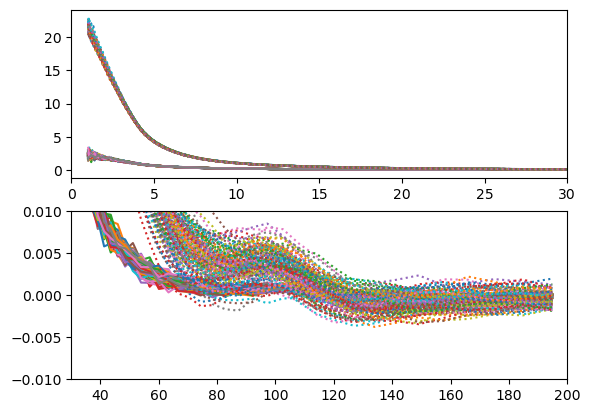

In [1]:
import h5py 
import os.path as op
import numpy as np
from glob import glob
from matplotlib import pyplot as plt

data_dir  = '/home/qezlou/HD2/HETDEX/cosmo/data/lognormal-mocks/'
fnames_oii = glob(op.join(data_dir, 'corr_oii_*.hdf5'))
fnames_lae = glob(op.join(data_dir, 'corr_lae_*.hdf5'))

print(f'oii files = {len(fnames_oii)} | lae files = {len(fnames_lae)}')

all_corr = {'oii': {'corr':[],
                    'r': [],
                    'Header': {}},
            'lae': {'corr':[],
                    'r': [],
                    'Header': {}}}
fig, ax = plt.subplots(2,1)
for fn in fnames_lae:
    with h5py.File(fn, 'r') as f:
        corr = f['corr'][:]
        r = f['r'][:]
        all_corr['lae']['corr'].append(f['corr'][:])
        all_corr['lae']['r'] = r
        all_corr['lae']['z'] = f['Header'].attrs['z']
        ax[1].plot(r, corr)  
        ax[0].plot(r, corr)

for fn in fnames_oii:
    with h5py.File(fn, 'r') as f:
        corr = f['corr'][:]
        r = f['r'][:]
        all_corr['oii']['corr'].append(f['corr'][:])
        all_corr['oii']['r'] = r
        all_corr['oii']['z'] = f['Header'].attrs['z']
        ax[1].plot(r, corr, ls='dotted')   
        ax[0].plot(r, corr, ls='dotted')
ax[1].set_xlim((30, 200))
ax[1].set_ylim((-0.01, .01))
ax[0].set_xlim((0, 30))
#ax[0].set_xscale('log')


In [5]:
def plot_pecentile(stype='lae', bao=True):
    fig, ax = plt.subplots()
    percents = np.array([2.28, 15.87, 50, 84.13, 97.27])
    pcnt = np.percentile(np.array(all_corr[stype]['corr']), percents, axis=0)
   
    if bao:
        y = pcnt[2] * all_corr[stype]['r']**2
        y_up_1sigma = pcnt[3] * all_corr[stype]['r']**2
        y_low_1sigma = pcnt[1]* all_corr[stype]['r']**2
        ax.set_xlim((50, 200))
    else:
        y = pcnt[2]
        y_up_1sigma = pcnt[3]
        y_low_1sigma = pcnt[1]
        ax.set_xlim((0, 50))
    ax.plot(all_corr[stype]['r'], y, label=stype)
    ax.fill_between(all_corr[stype]['r'], y_low_1sigma, y_up_1sigma, alpha=0.5)

    fig.suptitle(stype)
    fig.tight_layout()

    return fig, ax

(666600, 2)
(666600, 2)


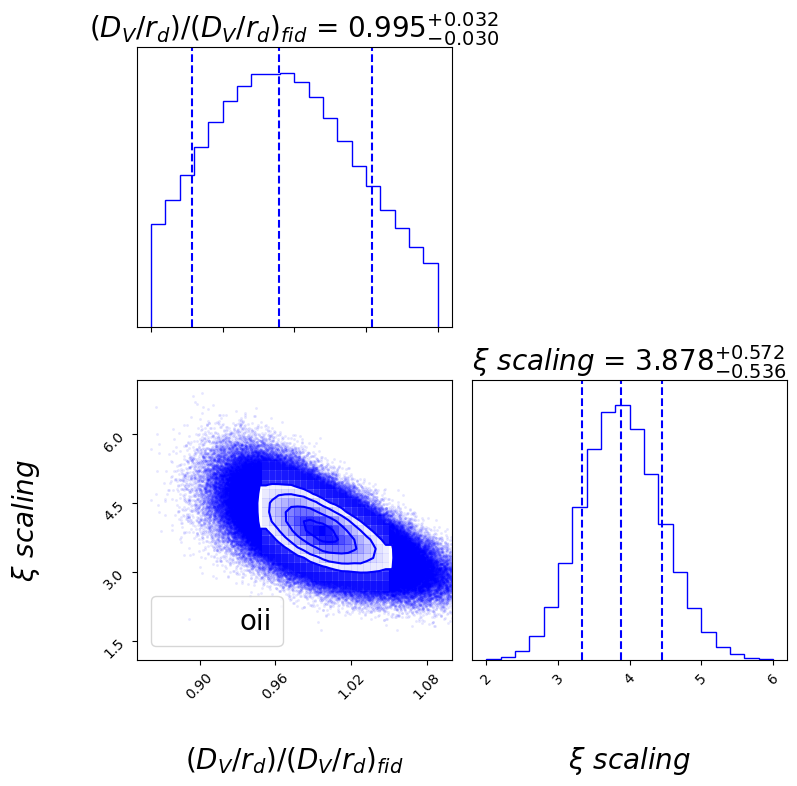

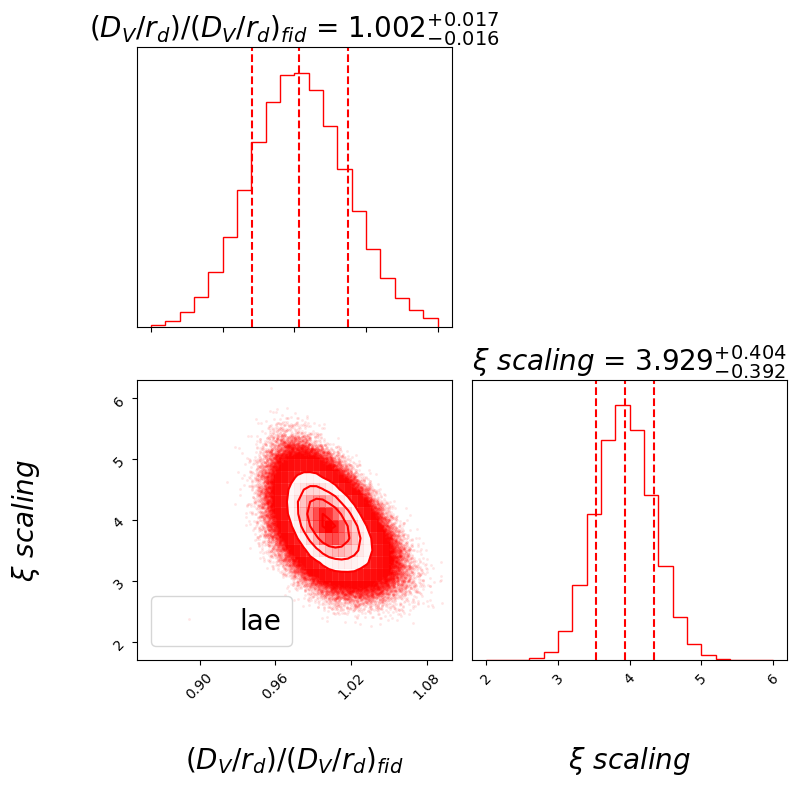

In [15]:
import h5py
import numpy as np 
import os.path as op
from matplotlib import pyplot as plt
import corner

data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/lognormal-mocks/'


stypes = ['oii', 'lae']
colors = ['b', 'r']
for i in range(2):
    fig = plt.figure(figsize=(8,8))
    with h5py.File(op.join(data_dir,f'samples_{stypes[i]}.hdf5'), 'r') as f:
        print(f['samples'].shape)
        samples = f['samples'][:]

        fig = corner.corner(samples, labels=[r"$(D_V / r_d) / (D_V / r_d)_{fid}$", r"$\xi \ scaling$"], 
                            truths=[0.6774, 0.8159], range=[(0.95, 1.05), (2,6)], 
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True, title_kwargs={"fontsize": 20},
                            label_kwargs={"fontsize": 20}, labelpad=0,
                            fig=fig, color=colors[i],title_fmt='.3f')
        ax = fig.get_axes()
        ax[2].set_xlim((0.85, 1.1))
        ax = fig.get_axes()
        ax[2].legend([f'{stypes[i]}'], fontsize=20)
        fig.tight_layout()


    

/home/qezlou/miniconda3/envs/het-cosmo/lib/python3.8/site-packages/mcfit/mcfit.py:126: UserWarning: The default value of lowring has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of lowring has been changed to False, "
/home/qezlou/miniconda3/envs/het-cosmo/lib/python3.8/site-packages/mcfit/mcfit.py:217: UserWarning: The default value of extrap has been changed to False, set it to True if you cannot reproduce previous results
  warnings.warn("The default value of extrap has been changed to False, "


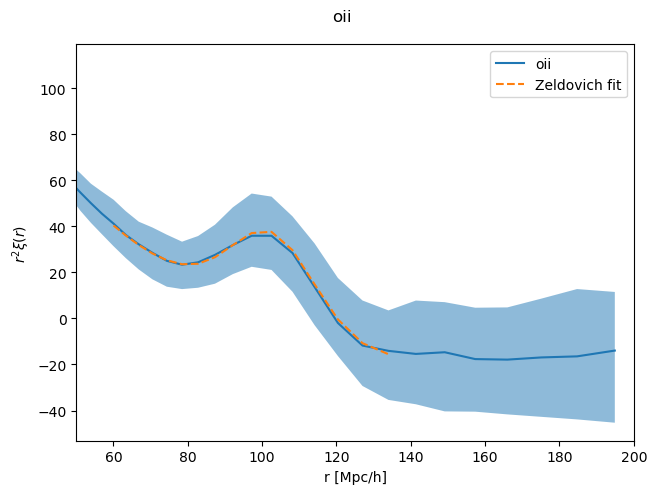

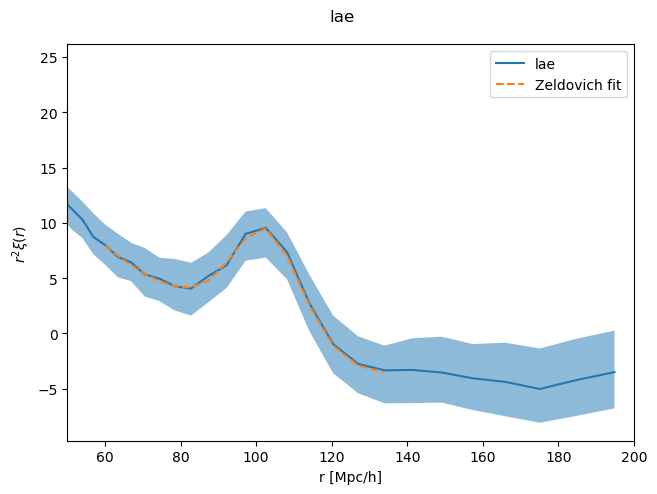

In [13]:
def get_fiducial_linear_corr(r, z):
    """
    Parameters
    ----------
    params : list
        List of parameters to fit. In this case, [h, sigma8]
    fixed_params : dict
        Dictionary of fixed parameters. In this case, {'r': r, 'z': z}
    Returns
    -------
    array
        Array of correlation function values
    """
    cosmo = cosmology.Planck15
    Plin = cosmology.ZeldovichPower(cosmo, redshift=z, transfer='EisensteinHu')
    cf_lin = cosmology.CorrelationFunction(Plin)
    return cf_lin(r)

def get_posterior_predictive(params, r, z, r_range=(60, 140)):
    ind = np.where((r >= r_range[0])*(r <= r_range[1]))
    data_r = r[ind]
    fid_r = np.linspace(np.log10(r[ind][0]), np.log10(r[ind][-1]), 1000)
    fid_r = 10**fid_r
    model_fid = get_fiducial_linear_corr(fid_r, z)
    pred =  params[1]*np.interp(data_r, params[0]*fid_r, model_fid)

    return data_r, pred

def plot_posterior_predictive(stype, params):
    r = all_corr[stype]['r']
    z = all_corr[stype]['z']
    corr = all_corr[stype]['corr']
    fit_r, pred = get_posterior_predictive(params, r, z)

    fig, ax = plot_pecentile(stype=stype, bao=True)

    ax.plot(fit_r, pred * fit_r**2, label='Zeldovich fit', ls='--')
    ax.set_xlabel('r [Mpc/h]')
    ax.set_ylabel(r'$r^2 \xi(r)$')
    ax.legend()
plot_posterior_predictive('oii', params=(1, 3.82))
plot_posterior_predictive('lae', params=(1, 3.89))